# Analyzing Atrato's Portuguese Migrants 🇵🇹

In [109]:
from util import *
import pandas as pd, geopandas as gpd, seaborn as sns, matplotlib.pyplot as plt
import plotly.graph_objects as gp, numpy as np, pylab as pl
from IPython.display import Markdown as md
%matplotlib inline

In [93]:
df = pd.read_excel('data/atrato-data.xlsx', converters={"naturality_place_id":str,
                                                        "naturality_city_id": str,
                                                        "naturality_state_id":str,
                                                        "passport_emission_id":str})
df = df[df.nationality=="Portuguese"].reset_index(drop=True)

## Demographics

#### Total of Migrants

In [112]:
md("There were {} Portuguese migrants in Atrato's Boarding Lists.".format(len(df)))

There were 195 Portuguese migrants in Atrato's Boarding Lists.

#### Gender and Civil Status

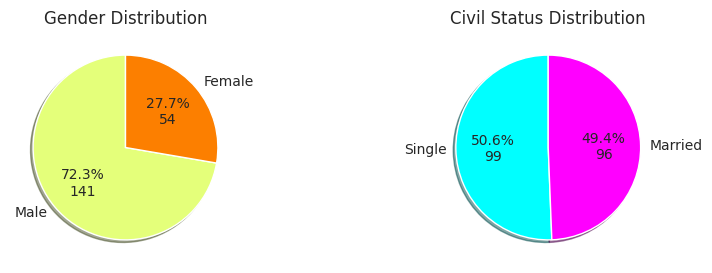

In [95]:
fig, axes = plt.subplots(ncols=2)

gender = df["gender"].to_frame("Gender").value_counts().to_frame("Total")
gender.plot.pie(title="Gender Distribution", figsize=(10,3), cmap="Wistia",y='Total',ylabel='',ax=axes[0],
                autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(df)*prct_value/100)),
                shadow=True, startangle=90, labels=["Male","Female"]).get_legend().remove()

civil_status = df["civil-status"].to_frame("Civil Status").value_counts().to_frame("Total")
civil_status.plot.pie(title="Civil Status Distribution", figsize=(10,3), cmap="cool",
                      autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(df)*prct_value/100)),
                      shadow=True, startangle=90, labels=["Single","Married"], y='Total', ylabel='',
                      ax=axes[1]).get_legend().remove()

#### Age

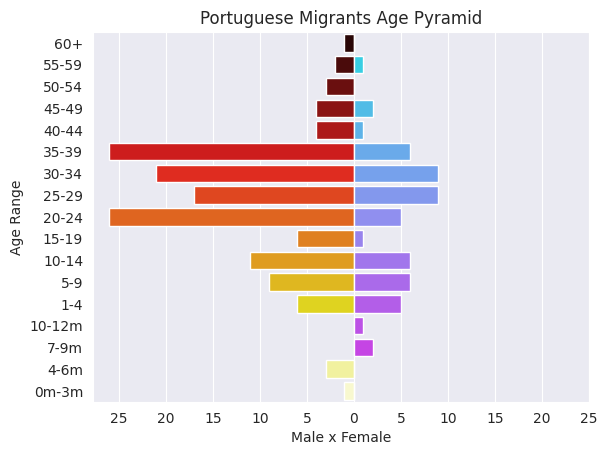

In [96]:
pyramid = generate_age_pyramid(df)
male_axis = sns.barplot(x='male', y='age', data=pyramid, order=pyramid["age"], palette="hot");
female_axis = sns.barplot(x='female', y='age', data=pyramid, order=pyramid["age"], palette="cool");
plt.title("Portuguese Migrants Age Pyramid");
plt.xticks(ticks=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25],
           labels=['25', '20', '15', '10', '5','0', '5', '10', '15', '20', '25']);
plt.xlabel("Male x Female"); plt.ylabel("Age Range");

#### Naturality

In [113]:
no_naturality = df[df['naturality_state'].isna()]
md("The homeland of {} Portuguese is unknown.".format(len(no_naturality)))

The homeland of 29 Portuguese is unknown.

The naturality of the rest is shown on the maps bellow:


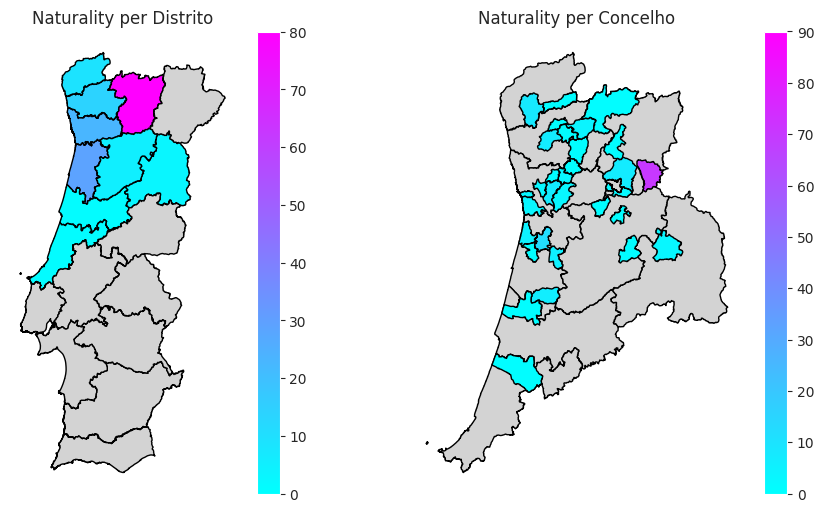

In [98]:
md ("The naturality of the rest is shown on the maps bellow:")
fig2, axes = plt.subplots(ncols=2, figsize=(12, 6))
distritos_map = generate_distritos_map(df)
distritos_map.plot(column = "count",cmap="cool", vmax=80, vmin=0, ax=axes[0], legend=True,
                   edgecolor="black", missing_kwds= dict(color = "lightgrey",))

distritos_concelhos_map = generate_distritos_map(df,False)
concelhos_map = generate_concelhos_map(df,False)
distritos_concelhos_map.plot(color="lightgrey", ax=axes[1], legend=True, edgecolor="black")
concelhos_map.plot(column="count", cmap="cool", vmax=90, vmin=0, ax=axes[1],
                   legend=True, edgecolor="black", missing_kwds=dict(color="lightgrey", ))
axes[0].axis("off"); axes[0].title.set_text("Naturality per Distrito");
axes[1].axis("off"); axes[1].title.set_text("Naturality per Concelho");

In [99]:
dd = distritos_map.copy()[["DI","Distrito","count"]]
dd["count"]=dd["count"].astype("Int64")
dd =dd.dropna().sort_values(by="count", ascending=False).drop(columns="DI").reset_index(drop=True)
display(dd.T);

cc = concelhos_map.copy()[["DICO","Concelho","count"]]
cc["count"]=cc["count"].astype("Int64")
cc =cc.dropna().sort_values(by="count", ascending=False).drop(columns="DICO").reset_index(drop=True)
display(cc.T.iloc[:, : 10]);

,0,1,2,3,4,5,6,7,8
Distrito,VILA REAL,AVEIRO,PORTO,BRAGA,VIANA DO CASTELO,VISEU,GUARDA,COIMBRA,LEIRIA
count,81,29,23,14,9,5,3,1,1


,0,1,2,3,4,5,6,7,8,9
Concelho,ALIJÓ,OLIVEIRA DE AZEMÉIS,PONTE DE LIMA,BRAGA,VILA REAL,PAREDES,ANADIA,OVAR,SEVER DO VOUGA,VIEIRA DO MINHO
count,70,12,8,7,7,7,6,5,5,4


## Travel

### Passports

In [100]:
passport_data=df.passport_emission_id.dropna().reset_index(drop=True).value_counts().to_frame("count")
passport_data.reset_index(inplace=True)
passport_data = passport_data.rename(columns = {'index':'DI'})
passport_data["DI"] = passport_data["DI"].astype(str)
passport_geodata = gpd.read_file("data/distritos.geojson")

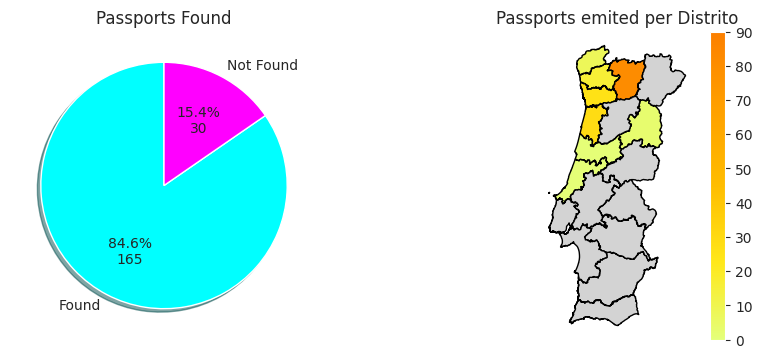

,0,1,2,3,4,5,6,7
Distrito,VILA REAL,AVEIRO,PORTO,BRAGA,VIANA DO CASTELO,GUARDA,COIMBRA,LEIRIA
count,81,29,26,16,8,3,1,1


In [101]:
fig, axes = plt.subplots(ncols=2)

passport = df["found_passport"].to_frame("Passports Found").value_counts().to_frame("Total")
passport.plot.pie(title="Passports Found", figsize=(10,4), cmap="cool",ax=axes[0], ylabel='',
                autopct=(lambda prct_value: "{:.1f}%\n{:.0f}".format(prct_value,len(df)*prct_value/100)),
                shadow=True, startangle=90, labels=["Found","Not Found"], y="Total").get_legend().remove()
plt.title("Passports emited per Distrito")
passport_map = passport_geodata.merge(passport_data, how='left', on='DI')
passport_map.plot(column = "count",cmap="Wistia",figsize=(15,4), vmax=90, vmin=0, ax=axes[1],
                   legend=True, edgecolor="black", missing_kwds= dict(color = "lightgrey",))
plt.axis("off")
plt.show()

dd = passport_map.copy()[["DI","Distrito","count"]]
dd["count"]=dd["count"].astype("Int64")
dd =dd.dropna().sort_values(by="count", ascending=False).drop(columns="DI").reset_index(drop=True)
display(dd.T)

### Embarkation

In [102]:
embarked = df.query("embarked == 'Yes'")
not_embarked = df.query("embarked == 'No'")
print("Out of the {} Portuguese in boarding lists:\n\t{} embarked in the Port of Lisbon"
      " \n\t{} did not embark, a solo traveler and a family"
      .format(len(df), len(embarked), len(not_embarked)))
print("\nAccording to the newspaper 'O Economista', published on Jan 8,"
      "the Port of Lisbon Police had the {} arrested because they tried to embark without passports. "
      "The family actually had a passport emited at the Civil Government of Vila Real, "
      "maybe they lost it before embarking or the information in it was false.".format(len(not_embarked)))

Out of the 195 Portuguese in boarding lists:
	189 embarked in the Port of Lisbon 
	6 did not embark, a solo traveler and a family

According to the newspaper 'O Economista', published on Jan 8,the Port of Lisbon Police had the 6 arrested because they tried to embark without passports. The family actually had a passport emited at the Civil Government of Vila Real, maybe they lost it before embarking or the information in it was false.


In [103]:
solo = embarked["solo_id"].dropna().astype(int).nunique()
families = embarked["family_id"].dropna().astype(int).nunique()
print("Passengers were made up of:\n\t{} families\n\t{} solo travelers"
      .format(families, solo))

Passengers were made up of:
	31 families
	85 solo travelers


### Tickets

In [104]:
paid= embarked.query("contract == 'Paid'")
c_locadora = 5 # It's unknow which passengers were the ones brought for Companhia Locadora
w_c_tait = embarked.query("contract == 'W.C. Tait'")
print("Regarding Passenger Tickets:\n\t{} paid for the passenger tickets\n\t{} were brought by William C. Tait & Cia.\n\t\t{} with subsidized tickets\n\t\t{} were single portuguese hired as servants by Companhia Locadora Previdência Doméstica\nAll of them were in 3rd Class/Steerage"
      .format(len(paid)-c_locadora, len(w_c_tait) + c_locadora, len(w_c_tait), c_locadora))

Regarding Passenger Tickets:
	98 paid for the passenger tickets
	91 were brought by William C. Tait & Cia.
		86 with subsidized tickets
		5 were single portuguese hired as servants by Companhia Locadora Previdência Doméstica
All of them were in 3rd Class/Steerage


#### Paying Migrants

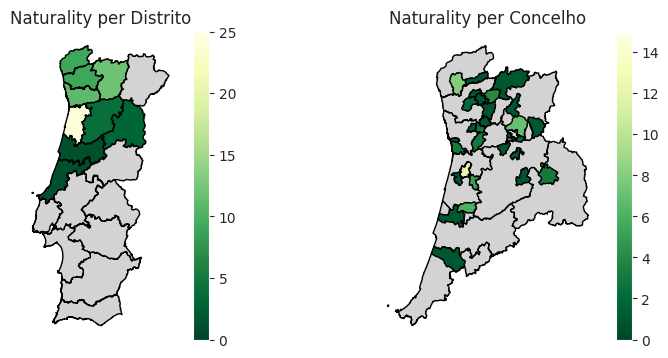

In [105]:
fig4, axes = plt.subplots(ncols=2, figsize=(10, 4))

distritos_map2 = generate_distritos_map(paid)
distritos_map2.plot(column="count", cmap="YlGn_r",vmax=25, vmin=0, ax=axes[0], legend=True,
                   edgecolor="black", missing_kwds=dict(color="lightgrey", ))
distritos_concelhos_map2 = generate_distritos_map(paid,False)
concelhos_map2 = generate_concelhos_map(paid,False)
distritos_concelhos_map2.plot(color="lightgrey", ax=axes[1], legend=True, edgecolor="black")
concelhos_map2.plot(column="count", cmap="YlGn_r", vmax=15, vmin=0, ax=axes[1],
                   legend=True, edgecolor="black", missing_kwds=dict(color="lightgrey", ))
axes[0].axis("off"); axes[0].title.set_text("Naturality per Distrito")
axes[1].axis("off"); axes[1].title.set_text("Naturality per Concelho")

#### Subsidized Migrants

The naturality of passangers brought by William C. Tait & Cia.:


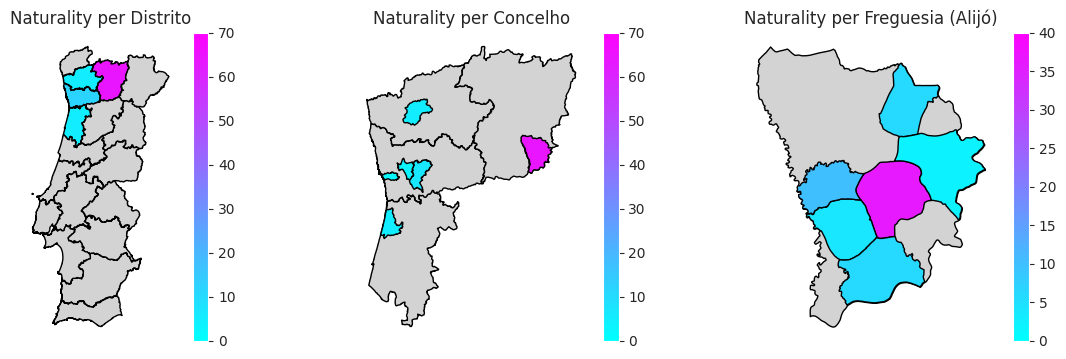

In [106]:
print("The naturality of passangers brought by William C. Tait & Cia.:")

fig3, axes = plt.subplots(ncols=3, figsize=(15, 4))

distritos_map = generate_distritos_map(w_c_tait)
distritos_map.plot(column="count", cmap="cool",vmax=70, vmin=0, ax=axes[0], legend=True,
                   edgecolor="black", missing_kwds=dict(color="lightgrey", ))

distritos_concelhos_map = generate_distritos_map(w_c_tait,False)
concelhos_map = generate_concelhos_map(w_c_tait,False)
distritos_concelhos_map.plot(color="lightgrey", ax=axes[1], legend=True, edgecolor="black")
concelhos_map.plot(column="count", cmap="cool", vmax=70, vmin=0, ax=axes[1],
                   legend=True, edgecolor="black", missing_kwds=dict(color="lightgrey", ))

alijo = w_c_tait.query("naturality_city == 'Alijó'")
alijo_concelhos_map = generate_concelhos_map(alijo,False)
alijo_freguesias_map = generate_freguesias_map(alijo,False)
alijo_concelhos_map.plot(color="lightgrey", ax=axes[2], legend=True, edgecolor="black")
alijo_freguesias_map.plot(column="count", cmap="cool",vmax=40, vmin=0, ax=axes[2], legend=True,
                   edgecolor="black", missing_kwds=dict(color="lightgrey", ))

axes[0].axis("off"); axes[0].title.set_text("Naturality per Distrito")
axes[1].axis("off"); axes[1].title.set_text("Naturality per Concelho")
axes[2].axis("off"); axes[2].title.set_text("Naturality per Freguesia (Alijó)")